# Forecasting Library Example Usage

In [1]:
from forecasting_library.datasets import load_caiso_data
from forecasting_library.forecasting.evaluation import backtest_model
from forecasting_library.forecasting.forecasting_api import ForecastingAPI
from forecasting_library.forecasting.preprocessing import preprocess_data
import matplotlib.pyplot as plt
import pandas as pd

### Load Data

In [2]:
data = load_caiso_data()
data.head()

,CAISO_system_load,temp_forecast_dayahead_bakersfield,temp_forecast_dayahead_los_angeles,temp_forecast_dayahead_san_francisco,dewpoint_forecast_dayahead_bakersfield,dewpoint_forecast_dayahead_los_angeles,dewpoint_forecast_dayahead_san_francisco
interval_start_time,,,,,,,
2020-01-01 00:00:00-08:00,21599.0,45.7,56.0,51.0,42.3,32.3,48.0
2020-01-01 01:00:00-08:00,20879.0,45.0,55.0,51.0,42.0,33.0,48.0
2020-01-01 02:00:00-08:00,20351.0,44.3,54.0,50.7,41.3,33.0,48.0
2020-01-01 03:00:00-08:00,20064.0,43.7,53.0,50.3,40.7,33.0,48.0
2020-01-01 04:00:00-08:00,20016.0,43.0,52.0,50.0,40.0,33.0,48.0


### Preprocess Data

In [3]:
lagged_features = [c for c in data if c != "CAISO_system_load"]
data_preprocessed = preprocess_data(
    data, 
    datetime_column="index", 
    lagged_features=lagged_features,
    feature_lags=[1,2], 
    target_col="CAISO_system_load",
    target_lags=[48, 72], # Cannot assign lag of <38 because the 24th hour in the day ahead market is 38 hours after 10 AM 
)
data_preprocessed.head()

,CAISO_system_load,temp_forecast_dayahead_bakersfield,temp_forecast_dayahead_los_angeles,temp_forecast_dayahead_san_francisco,dewpoint_forecast_dayahead_bakersfield,dewpoint_forecast_dayahead_los_angeles,dewpoint_forecast_dayahead_san_francisco,hour,day_of_week,month,...,temp_forecast_dayahead_san_francisco_lag_1,temp_forecast_dayahead_san_francisco_lag_2,dewpoint_forecast_dayahead_bakersfield_lag_1,dewpoint_forecast_dayahead_bakersfield_lag_2,dewpoint_forecast_dayahead_los_angeles_lag_1,dewpoint_forecast_dayahead_los_angeles_lag_2,dewpoint_forecast_dayahead_san_francisco_lag_1,dewpoint_forecast_dayahead_san_francisco_lag_2,CAISO_system_load_lag_48,CAISO_system_load_lag_72
interval_start_time,,,,,,,,,,,,,,,,,,,,,
2020-01-04 02:00:00-08:00,19673.0,45.3,55.3,51.7,42.0,50.7,45.3,2,5,1,...,52.0,52.3,43.0,43.7,53.0,53.0,46.0,46.0,19117.0,20351.0
2020-01-04 03:00:00-08:00,19538.0,44.7,54.7,51.3,41.0,48.3,44.7,3,5,1,...,51.7,52.0,42.0,43.0,50.7,53.0,45.3,46.0,19234.0,20064.0
2020-01-04 04:00:00-08:00,19825.0,44.0,54.0,51.0,40.0,46.0,44.0,4,5,1,...,51.3,51.7,41.0,42.0,48.3,50.7,44.7,45.3,19993.0,20016.0
2020-01-04 05:00:00-08:00,20515.0,43.3,53.3,51.3,40.3,46.3,45.0,5,5,1,...,51.0,51.3,40.0,41.0,46.0,48.3,44.0,44.7,21295.0,20342.0
2020-01-04 06:00:00-08:00,21407.0,42.7,52.7,51.7,40.7,46.7,46.0,6,5,1,...,51.3,51.0,40.3,40.0,46.3,46.0,45.0,44.0,23122.0,20734.0


### Split training and test data. 
Split off the final month (jul 2023) for test

In [4]:
X = data_preprocessed.drop(columns=["CAISO_system_load"])
y = data_preprocessed["CAISO_system_load"]
split_date = "2022-07-01" 

X_train, X_test = X.loc[X.index < split_date], X.loc[X.index >= split_date]
y_train, y_test = y.loc[y.index < split_date], y.loc[y.index >= split_date]

### Define Forecasting Run 

In [5]:
model_type = "xgboost"

# Define the Hyperparameter Grid for the Model
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [3, 6],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1.0],
}
xgb_run = ForecastingAPI(model_type=model_type)

### Train the Model Using the Complete Training Pipeline 
(from pre jul 2023 data)

In [6]:
xgb_run.train_pipeline(X_train, y_train, param_grid=param_grid, n_splits=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


### Make Predictions on test data 

In [7]:
predictions = xgb_run.forecast(X_test)

In [8]:
from sklearn.metrics import mean_absolute_error 
mean_absolute_error(predictions, y_test)

np.float64(1026.060867657239)

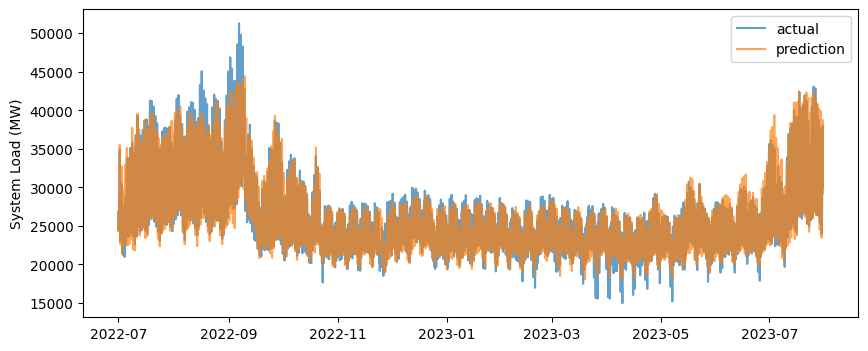

In [9]:
predictions = pd.Series(predictions, index=y_test.index)
plt.figure(figsize=[10,4])
plt.plot(y_test, label='actual', alpha=0.7)
plt.plot(predictions, label='prediction', alpha=0.7)
plt.ylabel("System Load (MW)")
plt.legend(); 

### Run Backtesting
- Run backtesting in 24-hour chunks (each day-ahead market) over the last year of data.
- Each test uses all historical data prior to the test day (D) to train the model used for its predictions.

In [10]:
import numpy as np
backtest_results, backtest_preds = xgb_run.backtest_model(X, y, n_splits=365, test_size=24)
average_mape = np.mean([r["MAPE"] for r in backtest_results])
average_mae = np.mean([r["MAE"] for r in backtest_results])

In [11]:
print(f"Average Mean Absolute Percent Error (MAPE) during backtesting: {100*average_mape:.2f}%")
print(f"Average Mean Absolute Error (MAE) during backtesting: {average_mae:.0f} MW")

Average Mean Absolute Percent Error (MAPE) during backtesting: 3.82%
Average Mean Absolute Error (MAE) during backtesting: 975 MW


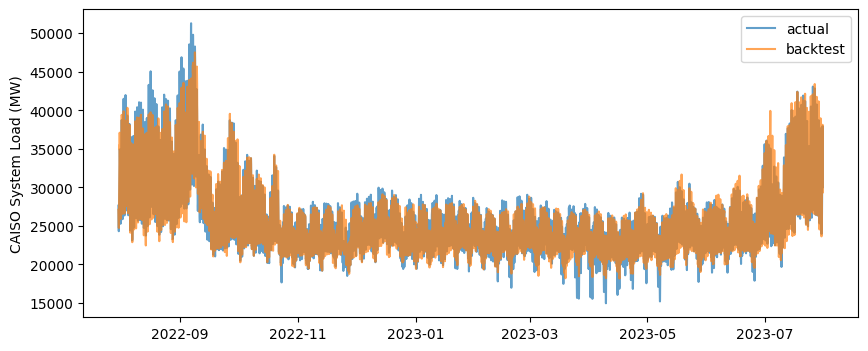

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
n_preds = len(backtest_preds)
backtest_preds = pd.Series(backtest_preds, index=y[-n_preds:].index)

plt.figure(figsize=[10,4])
plt.plot(y[-n_preds:],label="actual", alpha=0.7)
plt.plot(backtest_preds, label="backtest", alpha=0.7)
plt.ylabel("CAISO System Load (MW)")
plt.legend();